In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# import and normalize data

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure the images are in greyscale
    transforms.Resize((128, 128)),  # Resize images to 48x48 (if not already)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std for greyscale
])

train_dataset = torchvision.datasets.ImageFolder(root='./../fer2013plus/fer2013/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./../fer2013plus/fer2013/test', transform=transform)

In [ ]:
# check data shape
from collections import Counter
# Count the number of samples per class in the training set
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
train_counter = Counter(train_labels)

# Count the number of samples per class in the test set
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
test_counter = Counter(test_labels)

classes = train_dataset.classes

# Print the distribution
print("Training set class distribution:")
for i, class_name in enumerate(classes):
    print(f'{class_name:5s}: {train_counter[i]}')

print("\nTest set class distribution:")
for i, class_name in enumerate(classes):
    print(f'{class_name:5s}: {test_counter[i]}')

Training set class distribution:
anger: 2466
contempt: 165
disgust: 191
fear : 652
happiness: 7528
neutral: 10308
sadness: 3514
surprise: 3562

Test set class distribution:
anger: 644
contempt: 51
disgust: 57
fear : 167
happiness: 1827
neutral: 2597
sadness: 856
surprise: 900


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler


# given the the distribution of the train set is not balanced, we will use a weighted sampler
total_samples = len(train_dataset)

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


# Calculate class weights based on the training set distribution
class_weights = {class_id: total_samples / count for class_id, count in train_counter.items()}
class_weights_list = [class_weights[label] for label in train_labels]
print(class_weights)
print(len(class_weights_list))

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(class_weights_list, len(class_weights_list), replacement=True, )

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

{0: 11.510948905109489, 1: 172.03636363636363, 2: 148.61780104712042, 3: 43.53680981595092, 4: 3.770722635494155, 5: 2.7537834691501746, 6: 8.077973819009676, 7: 7.969118472768108}
28386


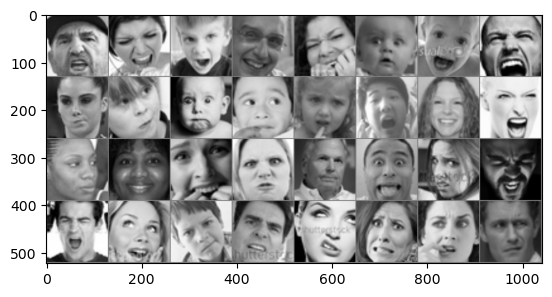

In [ ]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# define train and validation as a funcnion

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg = running_loss / len(train_loader)
        train_losses.append(avg)
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(running_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch + 1}/{num_epochs}, train Loss: {train_losses[-1]:.4f}, train Acc: {train_accuracies[-1]:.2f}%, validation Loss: {val_losses[-1]:.4f}, validation Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# plot training and validation loss
# Plotting the results
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


In [ ]:
# defining training parameters

# Define loss function and optimizer and other hyper parameters
num_classes = 8
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
wd = 0.001
num_epochs = 15

# Define ResNet Models (Changing stride size for each layer)

In [ ]:
# Import ResNet
import torchvision.models.resnet as resnet
import torch
import torch.nn as nn
import torch.optim as optim

# Predefine
conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock
device = torch.device('cuda')

torch.set_default_device("cuda")

## Layer 1: 1, Layer 2: 1, Layer 3: 2, Layer 4: 2

In [ ]:
# Define the model
# Dataset image size is 48x48 => 128x128

class ResNet_1122(nn.Module):
    def __init__(self, block, layers, num_classes=8, zero_init_residual=True):
        super(ResNet_1122, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1) # Change stride size
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Layer 1: 1, Layer 2: 2, Layer 3: 1, Layer 4: 2

In [ ]:
# Define the model
# Dataset image size is 48x48 => 128x128

class ResNet_1212(nn.Module):
    def __init__(self, block, layers, num_classes=8, zero_init_residual=True):
        super(ResNet_1212, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1) # Change stride size
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Layer 1: 1, Layer 2: 2, Layer 3: 2, Layer 4: 1

In [ ]:
# Define the model
# Dataset image size is 48x48 => 128x128

class ResNet_1221(nn.Module):
    def __init__(self, block, layers, num_classes=8, zero_init_residual=True):
        super(ResNet_1221, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1) # Change stride size

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Train on 128x128 images

In [ ]:
# Define the model
resnet50_1122 = ResNet_1122(resnet.Bottleneck, [3, 4, 6, 3]).to(device)
resnet50_1212 = ResNet_1212(resnet.Bottleneck, [3, 4, 6, 3]).to(device)
resnet50_1221 = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3]).to(device)

In [ ]:
from torchsummary import summary

# Print the model architecture
summary(resnet50_1122, input_size=(1, 128, 128), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           3,136
       BatchNorm2d-2           [-1, 64, 62, 62]             128
              ReLU-3           [-1, 64, 62, 62]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
            Conv2d-5           [-1, 64, 31, 31]           4,096
       BatchNorm2d-6           [-1, 64, 31, 31]             128
              ReLU-7           [-1, 64, 31, 31]               0
            Conv2d-8           [-1, 64, 31, 31]          36,864
       BatchNorm2d-9           [-1, 64, 31, 31]             128
             ReLU-10           [-1, 64, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]          16,384
      BatchNorm2d-12          [-1, 256, 31, 31]             512
           Conv2d-13          [-1, 256, 31, 31]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
summary(resnet50_1212, input_size=(1, 128, 128), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           3,136
       BatchNorm2d-2           [-1, 64, 62, 62]             128
              ReLU-3           [-1, 64, 62, 62]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
            Conv2d-5           [-1, 64, 31, 31]           4,096
       BatchNorm2d-6           [-1, 64, 31, 31]             128
              ReLU-7           [-1, 64, 31, 31]               0
            Conv2d-8           [-1, 64, 31, 31]          36,864
       BatchNorm2d-9           [-1, 64, 31, 31]             128
             ReLU-10           [-1, 64, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]          16,384
      BatchNorm2d-12          [-1, 256, 31, 31]             512
           Conv2d-13          [-1, 256, 31, 31]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
summary(resnet50_1221, input_size=(1, 128, 128), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           3,136
       BatchNorm2d-2           [-1, 64, 62, 62]             128
              ReLU-3           [-1, 64, 62, 62]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
            Conv2d-5           [-1, 64, 31, 31]           4,096
       BatchNorm2d-6           [-1, 64, 31, 31]             128
              ReLU-7           [-1, 64, 31, 31]               0
            Conv2d-8           [-1, 64, 31, 31]          36,864
       BatchNorm2d-9           [-1, 64, 31, 31]             128
             ReLU-10           [-1, 64, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]          16,384
      BatchNorm2d-12          [-1, 256, 31, 31]             512
           Conv2d-13          [-1, 256, 31, 31]          16,384
      BatchNorm2d-14          [-1, 256,

# Train the models, find the best model

/home/asm6788/anaconda3/envs/crack/lib/python3.11/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)
/home/asm6788/anaconda3/envs/crack/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/15, train Loss: 1.9426, train Acc: 23.56%, validation Loss: 1.9150, validation Acc: 17.97%
Epoch 2/15, train Loss: 1.7112, train Acc: 34.10%, validation Loss: 1.8292, validation Acc: 21.92%
Epoch 3/15, train Loss: 1.4305, train Acc: 44.44%, validation Loss: 1.7859, validation Acc: 24.82%
Epoch 4/15, train Loss: 1.2215, train Acc: 51.48%, validation Loss: 1.7557, validation Acc: 29.68%
Epoch 5/15, train Loss: 1.1230, train Acc: 55.63%, validation Loss: 1.6254, validation Acc: 37.55%
Epoch 6/15, train Loss: 1.0300, train Acc: 59.92%, validation Loss: 1.4744, validation Acc: 42.03%
Epoch 7/15, train Loss: 0.9531, train Acc: 63.20%, validation Loss: 1.5174, validation Acc: 43.06%
Epoch 8/15, train Loss: 0.8828, train Acc: 66.58%, validation Loss: 1.6766, validation Acc: 34.61%
Epoch 9/15, train Loss: 0.8191, train Acc: 68.85%, validation Loss: 1.4289, validation Acc: 46.61%
Epoch 10/15, train Loss: 0.7656, train Acc: 71.02%, validation Loss: 1.5842, validation Acc: 44.60%
Epoch 11/

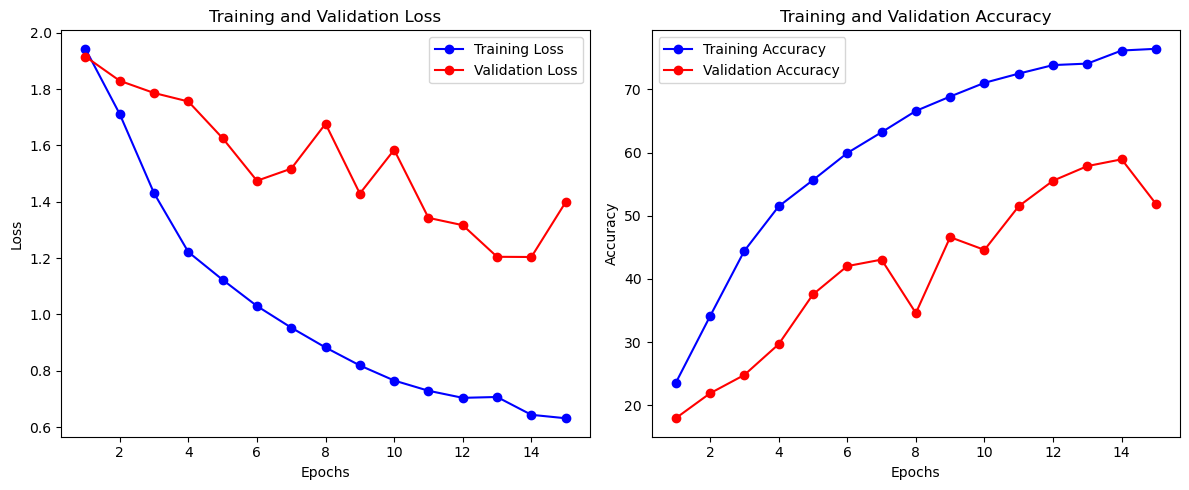

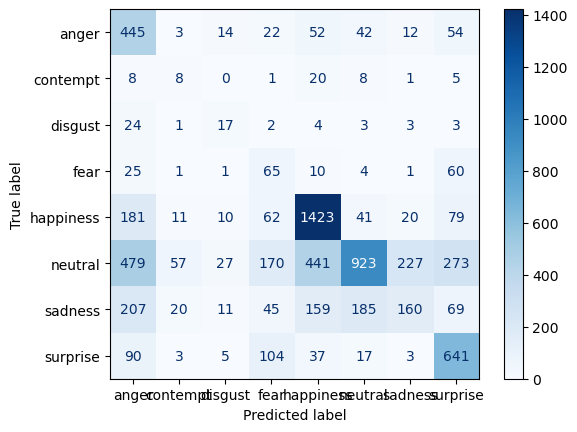

In [ ]:
optimizer = optim.Adam(resnet50_1122.parameters(), lr=learning_rate, weight_decay=wd)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(resnet50_1122, train_loader, test_loader, criterion, optimizer, num_epochs)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels)

Epoch 1/15, train Loss: 1.9151, train Acc: 25.09%, validation Loss: 2.3731, validation Acc: 9.73%
Epoch 2/15, train Loss: 1.6707, train Acc: 35.55%, validation Loss: 1.9914, validation Acc: 15.93%
Epoch 3/15, train Loss: 1.3888, train Acc: 46.47%, validation Loss: 2.7751, validation Acc: 28.03%
Epoch 4/15, train Loss: 1.1568, train Acc: 55.00%, validation Loss: 1.5770, validation Acc: 34.70%
Epoch 5/15, train Loss: 1.0201, train Acc: 60.96%, validation Loss: 1.6090, validation Acc: 35.89%
Epoch 6/15, train Loss: 0.9209, train Acc: 65.03%, validation Loss: 1.4850, validation Acc: 49.37%
Epoch 7/15, train Loss: 0.8397, train Acc: 68.40%, validation Loss: 1.2779, validation Acc: 50.60%
Epoch 8/15, train Loss: 0.7780, train Acc: 71.19%, validation Loss: 1.2568, validation Acc: 54.56%
Epoch 9/15, train Loss: 0.7190, train Acc: 73.35%, validation Loss: 1.2960, validation Acc: 54.18%
Epoch 10/15, train Loss: 0.6875, train Acc: 74.73%, validation Loss: 1.2173, validation Acc: 56.13%
Epoch 11/1

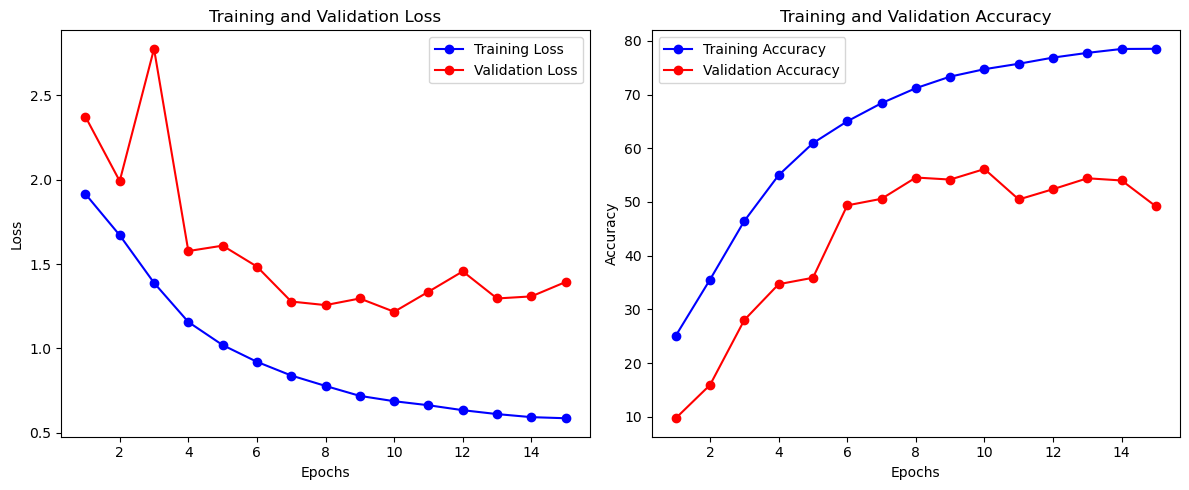

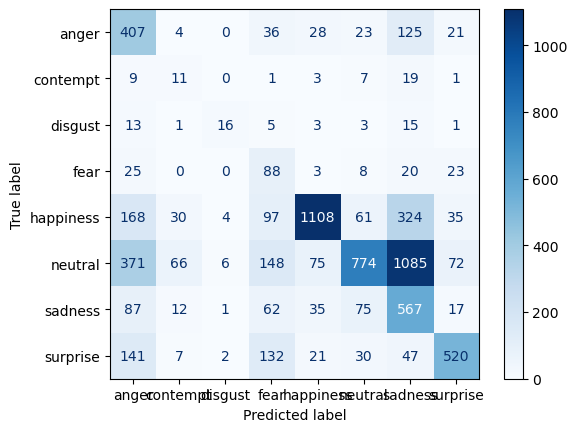

In [ ]:
optimizer = optim.Adam(resnet50_1212.parameters(), lr=learning_rate, weight_decay=wd)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(resnet50_1212, train_loader, test_loader, criterion, optimizer, num_epochs)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels)

Epoch 1/15, train Loss: 1.9093, train Acc: 25.29%, validation Loss: 1.8776, validation Acc: 22.64%
Epoch 2/15, train Loss: 1.6546, train Acc: 36.25%, validation Loss: 1.7524, validation Acc: 26.20%
Epoch 3/15, train Loss: 1.3557, train Acc: 47.77%, validation Loss: 1.4647, validation Acc: 38.26%
Epoch 4/15, train Loss: 1.0991, train Acc: 58.45%, validation Loss: 1.4482, validation Acc: 38.51%
Epoch 5/15, train Loss: 0.9669, train Acc: 63.60%, validation Loss: 1.2382, validation Acc: 53.66%
Epoch 6/15, train Loss: 0.8473, train Acc: 68.36%, validation Loss: 1.3156, validation Acc: 48.09%
Epoch 7/15, train Loss: 0.7810, train Acc: 71.04%, validation Loss: 1.2804, validation Acc: 52.58%
Epoch 8/15, train Loss: 0.7036, train Acc: 73.99%, validation Loss: 1.3557, validation Acc: 49.32%
Epoch 9/15, train Loss: 0.6636, train Acc: 75.84%, validation Loss: 1.1060, validation Acc: 60.76%
Epoch 10/15, train Loss: 0.6344, train Acc: 76.71%, validation Loss: 1.2253, validation Acc: 56.46%
Epoch 11/

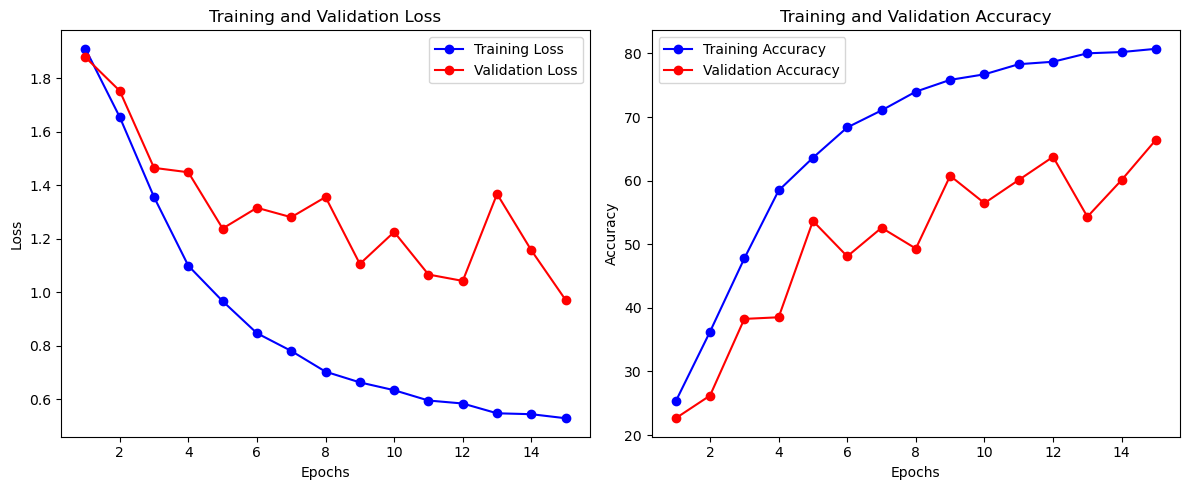

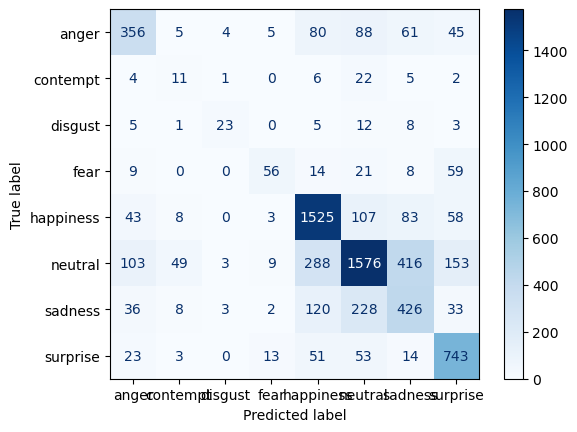

In [ ]:
optimizer = optim.Adam(resnet50_1221.parameters(), lr=learning_rate, weight_decay=wd)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(resnet50_1221, train_loader, test_loader, criterion, optimizer, num_epochs)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels)

# Hyperparameter tuning with optimal model

In [ ]:
# hyper parameter tuning
from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': ['SGD', 'Adam'],
    'weight_decay': [0.0001, 0.001, 0.01]
}

best_params = None
best_val_accuracy = 0

for params in ParameterGrid(param_grid):
    print(params)
    # Initialize the model, criterion, and optimizer with the current hyperparameters
    model = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3]).to(device) # Choose ResNet50 with Layer 4 has stride=1
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    # Update data loaders with the current batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], sampler=sampler)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # Train the model
    _, _, _, val_accuracies, _, _ = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

    # Get the best validation accuracy for the current hyperparameters
    max_val_accuracy = max(val_accuracies)
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_params = params

print(f'Best Hyperparameters: {best_params}')
print(f'Best Validation Accuracy: {best_val_accuracy}')

{'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.0001}
Epoch 1/15, train Loss: 2.0174, train Acc: 19.98%, validation Loss: 2.2614, validation Acc: 11.79%
Epoch 2/15, train Loss: 1.9506, train Acc: 24.40%, validation Loss: 1.9526, validation Acc: 24.82%
Epoch 3/15, train Loss: 1.8892, train Acc: 28.37%, validation Loss: 2.8466, validation Acc: 13.59%
Epoch 4/15, train Loss: 1.8405, train Acc: 31.03%, validation Loss: 2.4066, validation Acc: 14.38%
Epoch 5/15, train Loss: 1.7622, train Acc: 34.65%, validation Loss: 2.6156, validation Acc: 11.68%
Epoch 6/15, train Loss: 1.6799, train Acc: 38.22%, validation Loss: 2.1344, validation Acc: 14.16%
Epoch 7/15, train Loss: 1.5835, train Acc: 41.87%, validation Loss: 3.5708, validation Acc: 3.61%
Epoch 8/15, train Loss: 1.4937, train Acc: 45.38%, validation Loss: 2.3862, validation Acc: 15.76%
Epoch 9/15, train Loss: 1.4043, train Acc: 48.38%, validation Loss: 2.4982, validation Acc: 13.41%
Epoch 10/15, train Loss: 1.3029, tr

/home/asm6788/anaconda3/envs/crack/lib/python3.11/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


Epoch 1/15, train Loss: 2.0160, train Acc: 19.97%, validation Loss: 2.0476, validation Acc: 14.61%
Epoch 2/15, train Loss: 1.9693, train Acc: 24.08%, validation Loss: 2.1526, validation Acc: 15.14%
Epoch 3/15, train Loss: 1.9354, train Acc: 26.35%, validation Loss: 2.0043, validation Acc: 17.10%
Epoch 4/15, train Loss: 1.8957, train Acc: 28.81%, validation Loss: 1.9689, validation Acc: 17.35%
Epoch 5/15, train Loss: 1.8539, train Acc: 31.37%, validation Loss: 2.1281, validation Acc: 11.45%
Epoch 6/15, train Loss: 1.8116, train Acc: 33.66%, validation Loss: 2.1989, validation Acc: 9.33%
Epoch 7/15, train Loss: 1.7780, train Acc: 34.78%, validation Loss: 1.9953, validation Acc: 18.30%
Epoch 8/15, train Loss: 1.7164, train Acc: 37.38%, validation Loss: 2.0656, validation Acc: 17.35%
Epoch 9/15, train Loss: 1.6655, train Acc: 39.82%, validation Loss: 2.1196, validation Acc: 12.47%
Epoch 10/15, train Loss: 1.6066, train Acc: 41.95%, validation Loss: 2.0618, validation Acc: 16.50%
Epoch 11/1

Epoch 1/30, train Loss: 1.7003, train Acc: 35.01%, validation Loss: 1.7065, validation Acc: 26.30%
Epoch 2/30, train Loss: 0.9996, train Acc: 62.65%, validation Loss: 1.5916, validation Acc: 42.95%
Epoch 3/30, train Loss: 0.7121, train Acc: 73.51%, validation Loss: 1.4766, validation Acc: 49.71%
Epoch 4/30, train Loss: 0.5749, train Acc: 78.97%, validation Loss: 1.2792, validation Acc: 55.01%
Epoch 5/30, train Loss: 0.4946, train Acc: 81.90%, validation Loss: 1.1907, validation Acc: 59.44%
Epoch 6/30, train Loss: 0.4261, train Acc: 84.24%, validation Loss: 1.0429, validation Acc: 68.85%
Epoch 7/30, train Loss: 0.3921, train Acc: 85.63%, validation Loss: 1.0290, validation Acc: 66.70%
Epoch 8/30, train Loss: 0.3574, train Acc: 86.97%, validation Loss: 1.0857, validation Acc: 64.33%
Epoch 9/30, train Loss: 0.3072, train Acc: 88.84%, validation Loss: 1.0693, validation Acc: 67.54%
Epoch 10/30, train Loss: 0.2919, train Acc: 89.33%, validation Loss: 1.1160, validation Acc: 66.50%
Epoch 11/

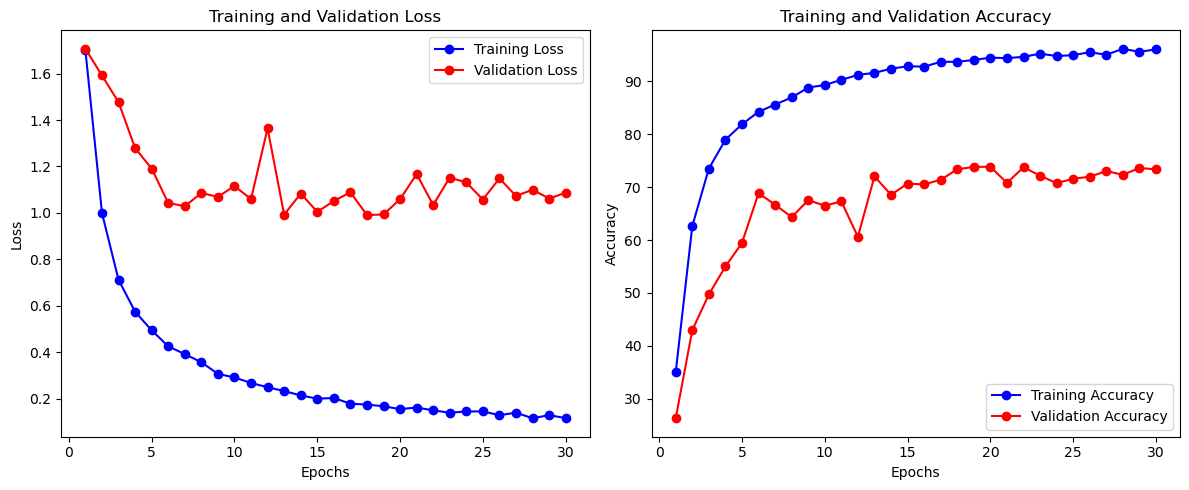

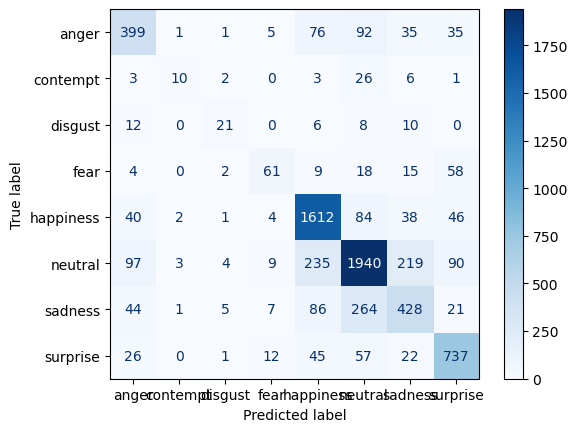

In [ ]:
# Retrain the model with the hyperparameter with the best validation accuracy
model = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 30, all_preds, all_labels)

# Save the model
torch.save(model.state_dict(), 'resnet_best_val_model.pth')

Epoch 1/30, train Loss: 1.7966, train Acc: 31.99%, validation Loss: 2.0639, validation Acc: 24.68%
Epoch 2/30, train Loss: 1.0092, train Acc: 61.90%, validation Loss: 1.8017, validation Acc: 36.06%
Epoch 3/30, train Loss: 0.6975, train Acc: 74.22%, validation Loss: 1.1553, validation Acc: 58.59%
Epoch 4/30, train Loss: 0.5048, train Acc: 81.56%, validation Loss: 1.1514, validation Acc: 60.80%
Epoch 5/30, train Loss: 0.4015, train Acc: 85.63%, validation Loss: 1.0714, validation Acc: 63.47%
Epoch 6/30, train Loss: 0.3082, train Acc: 89.29%, validation Loss: 1.4435, validation Acc: 54.90%
Epoch 7/30, train Loss: 0.2480, train Acc: 91.21%, validation Loss: 1.2376, validation Acc: 62.22%
Epoch 8/30, train Loss: 0.2015, train Acc: 92.98%, validation Loss: 1.4401, validation Acc: 60.02%
Epoch 9/30, train Loss: 0.1703, train Acc: 94.11%, validation Loss: 1.2728, validation Acc: 63.98%
Epoch 10/30, train Loss: 0.1399, train Acc: 95.22%, validation Loss: 1.2448, validation Acc: 63.21%
Epoch 11/

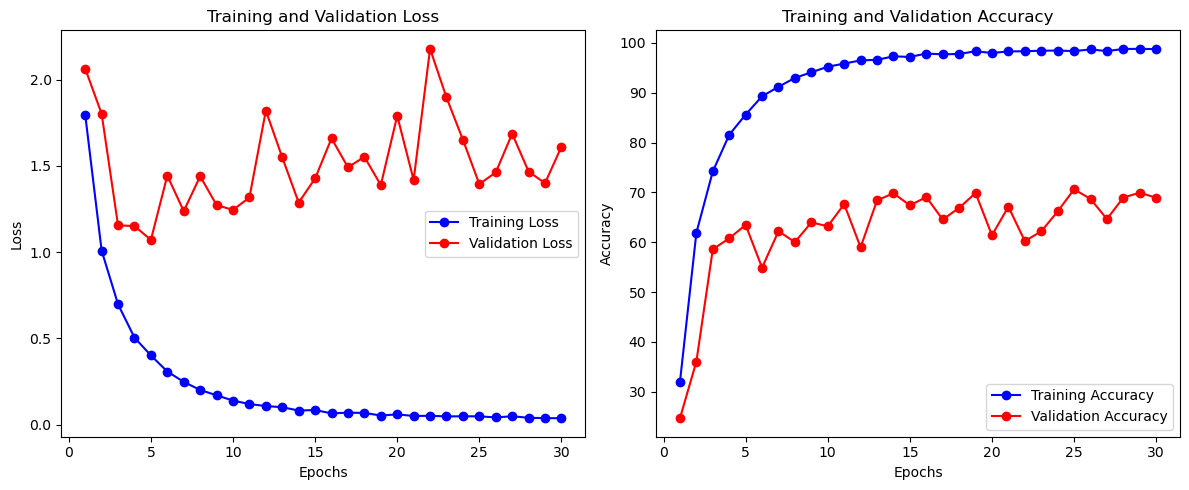

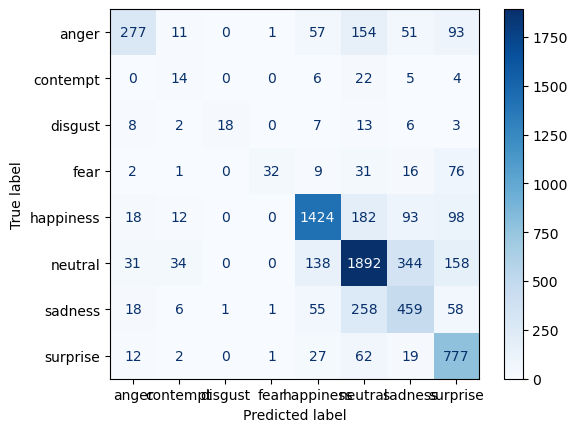

In [ ]:
# Retrain the model with the hyperparameter with the best train accuracy
model = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 30, all_preds, all_labels)

# Save the model
torch.save(model.state_dict(), 'resnet_best_train_model.pth')

Epoch 1/30, train Loss: 1.7977, train Acc: 32.12%, validation Loss: 1.7598, validation Acc: 31.65%
Epoch 2/30, train Loss: 1.0113, train Acc: 61.92%, validation Loss: 2.2903, validation Acc: 25.13%
Epoch 3/30, train Loss: 0.6496, train Acc: 76.18%, validation Loss: 1.1133, validation Acc: 58.74%
Epoch 4/30, train Loss: 0.4921, train Acc: 82.30%, validation Loss: 1.1662, validation Acc: 58.85%
Epoch 5/30, train Loss: 0.3920, train Acc: 85.80%, validation Loss: 1.1052, validation Acc: 63.32%
Epoch 6/30, train Loss: 0.3266, train Acc: 88.37%, validation Loss: 1.0778, validation Acc: 67.12%
Epoch 7/30, train Loss: 0.2856, train Acc: 89.98%, validation Loss: 1.1244, validation Acc: 63.90%
Epoch 8/30, train Loss: 0.2494, train Acc: 91.30%, validation Loss: 1.2334, validation Acc: 59.60%
Epoch 9/30, train Loss: 0.2186, train Acc: 92.51%, validation Loss: 1.5310, validation Acc: 59.66%
Epoch 10/30, train Loss: 0.2039, train Acc: 93.08%, validation Loss: 1.3006, validation Acc: 62.09%
Epoch 11/

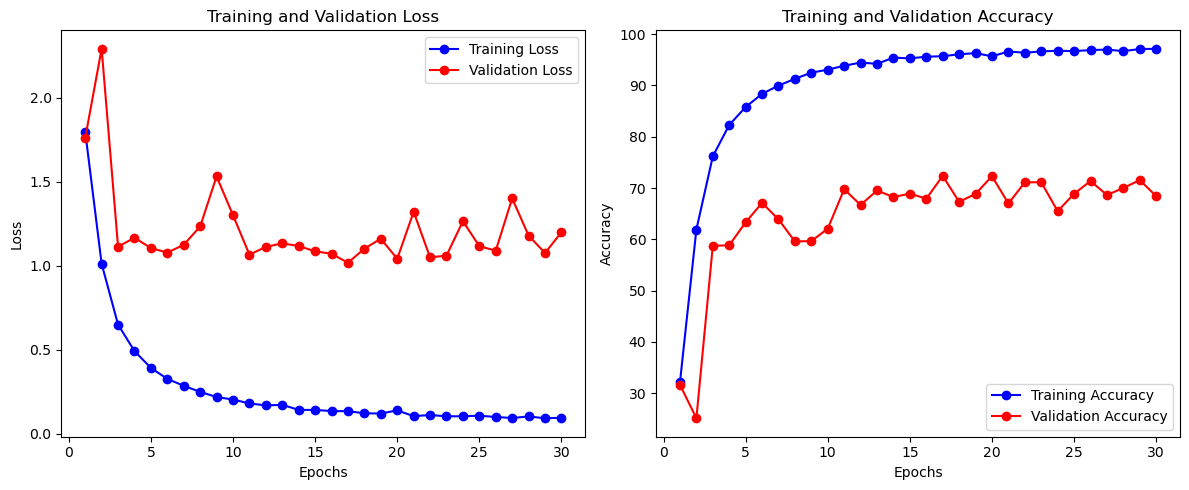

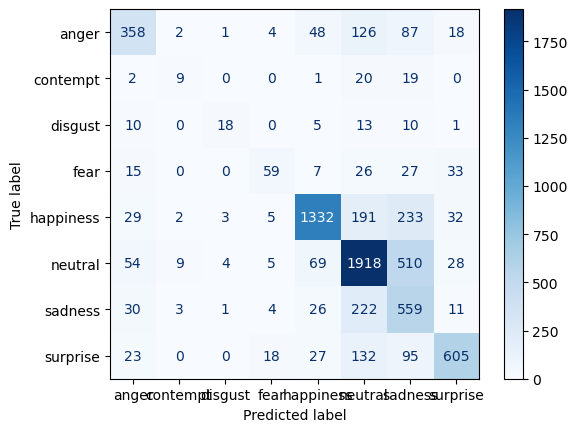

In [ ]:
# Retrain the model with the hyperparameter with the second best validation accuracy
model = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 30, all_preds, all_labels)

# Save the model
torch.save(model.state_dict(), 'resnet_2nd_best_val_model.pth')

Epoch 1/30, train Loss: 1.6691, train Acc: 36.70%, validation Loss: 1.5771, validation Acc: 39.60%
Epoch 2/30, train Loss: 0.9165, train Acc: 65.45%, validation Loss: 2.1211, validation Acc: 34.29%
Epoch 3/30, train Loss: 0.6307, train Acc: 76.54%, validation Loss: 1.2129, validation Acc: 56.02%
Epoch 4/30, train Loss: 0.4762, train Acc: 82.53%, validation Loss: 1.4250, validation Acc: 52.05%
Epoch 5/30, train Loss: 0.3788, train Acc: 86.31%, validation Loss: 1.1368, validation Acc: 64.38%
Epoch 6/30, train Loss: 0.3069, train Acc: 88.98%, validation Loss: 1.3091, validation Acc: 62.61%
Epoch 7/30, train Loss: 0.2666, train Acc: 90.53%, validation Loss: 1.1491, validation Acc: 65.33%
Epoch 8/30, train Loss: 0.2184, train Acc: 92.62%, validation Loss: 1.2816, validation Acc: 62.74%
Epoch 9/30, train Loss: 0.1765, train Acc: 93.89%, validation Loss: 1.2625, validation Acc: 65.85%
Epoch 10/30, train Loss: 0.1629, train Acc: 94.53%, validation Loss: 1.2095, validation Acc: 67.35%
Epoch 11/

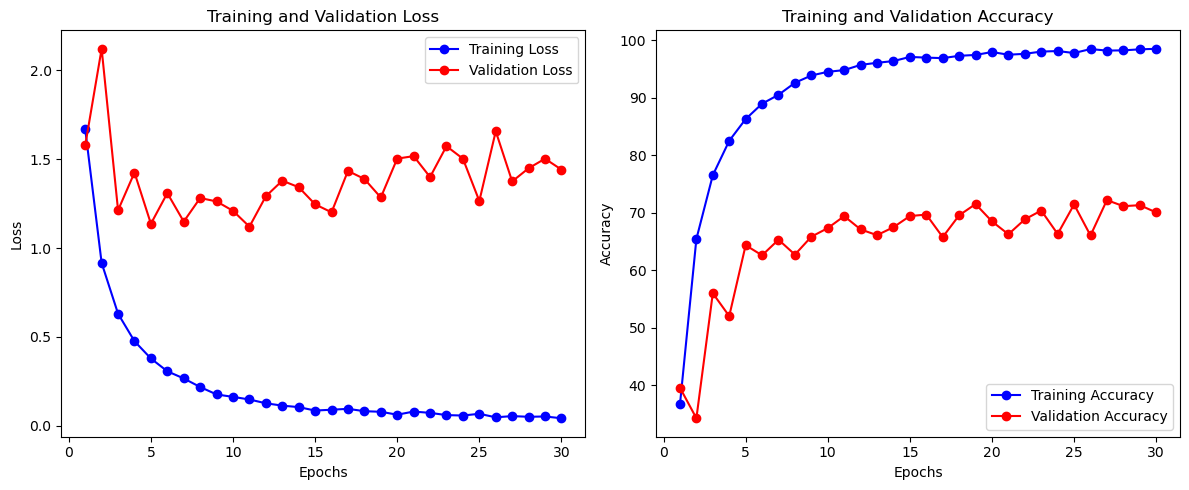

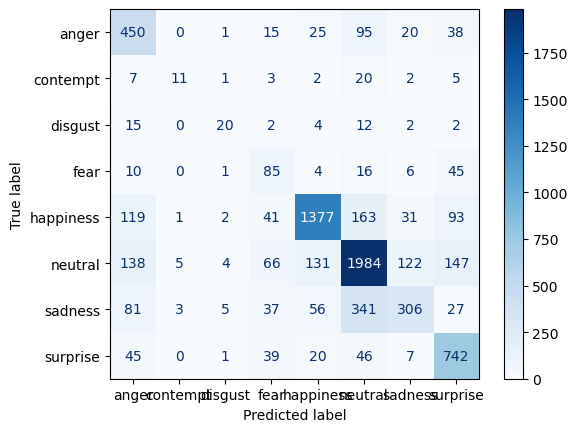

In [ ]:
# Retrain the model with the hyperparameter with the second best train accuracy
model = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 30, all_preds, all_labels)

# Save the model
torch.save(model.state_dict(), 'resnet_2nd_best_train_model.pth')

# Train the final model

Epoch 1/100, train Loss: 1.6962, train Acc: 35.25%, validation Loss: 1.7451, validation Acc: 32.82%
Epoch 2/100, train Loss: 0.9935, train Acc: 62.85%, validation Loss: 1.5648, validation Acc: 48.43%
Epoch 3/100, train Loss: 0.7103, train Acc: 73.85%, validation Loss: 1.1028, validation Acc: 61.23%
Epoch 4/100, train Loss: 0.5851, train Acc: 78.73%, validation Loss: 1.2906, validation Acc: 54.80%
Epoch 5/100, train Loss: 0.5050, train Acc: 81.66%, validation Loss: 1.2452, validation Acc: 55.91%
Epoch 6/100, train Loss: 0.4449, train Acc: 83.69%, validation Loss: 1.1470, validation Acc: 61.91%
Epoch 7/100, train Loss: 0.3998, train Acc: 85.61%, validation Loss: 1.0486, validation Acc: 63.49%
Epoch 8/100, train Loss: 0.3553, train Acc: 87.26%, validation Loss: 1.0381, validation Acc: 64.30%
Epoch 9/100, train Loss: 0.3283, train Acc: 88.06%, validation Loss: 1.1347, validation Acc: 62.90%
Epoch 10/100, train Loss: 0.3048, train Acc: 88.93%, validation Loss: 1.0309, validation Acc: 70.24%

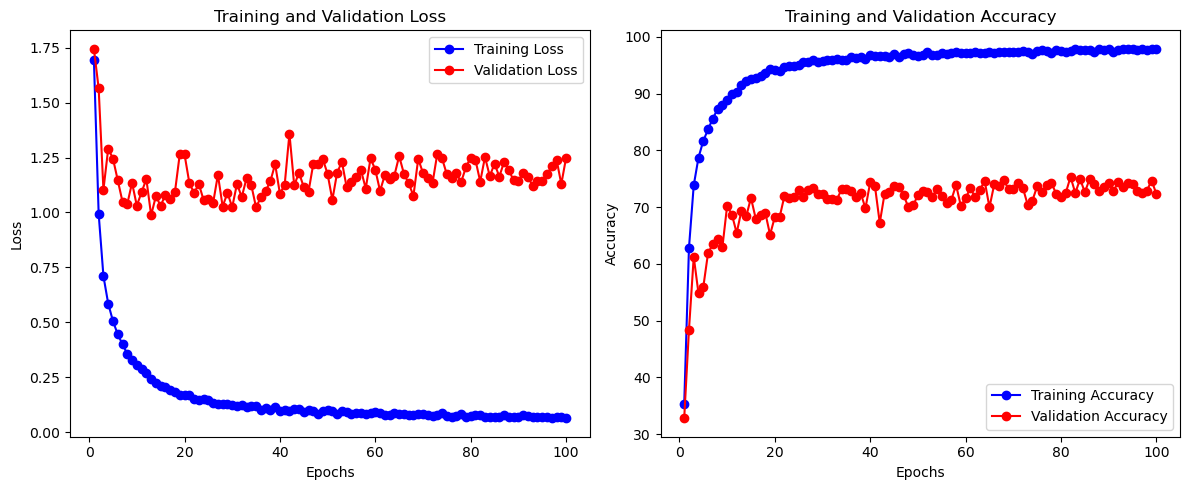

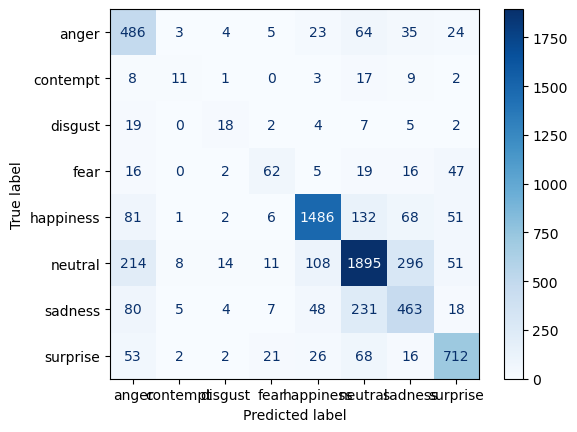

In [ ]:
# Retrain the model with the hyperparameter with the best validation accuracy
model = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 100, all_preds, all_labels)

# Save the model
torch.save(model.state_dict(), 'resnet_best_model.pth')

# Test the model

In [ ]:
# Test the model (percentage of correct predictions)

num_classes = 8
model = ResNet_1221(resnet.Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
model.load_state_dict(torch.load('resnet_best_model.pth'))
model = model.to(device)
model.eval()

ResNet_1221(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1)

Accuracy of the network on the test images: 72.29%
Accuracy of anger: 75.31%
Accuracy of contempt: 21.57%
Accuracy of disgust: 31.58%
Accuracy of fear: 37.13%
Accuracy of happiness: 81.34%
Accuracy of neutral: 72.97%
Accuracy of sadness: 54.09%
Accuracy of surprise: 79.11%


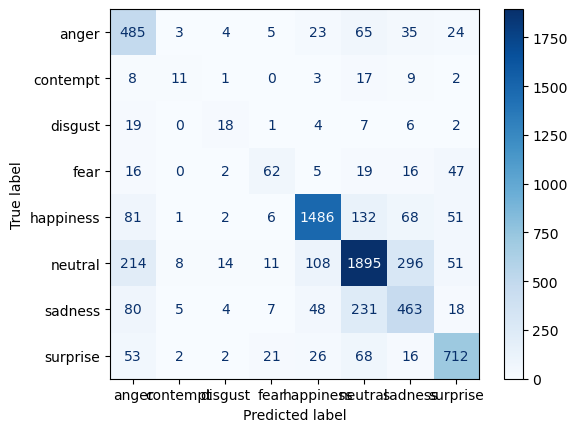

: 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

correct = 0
total = 0

# Lists to store all labels and predictions for confusion matrix
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

# Test the model (accuracy per class)
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(num_classes):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()